# **Instructions on how to run the code on google colab**

Before running the Jupyter notebook, run the following commands to ensure the notebook can run smoothly

```
conda create -n BT4012_Assignment2 python=3.7 #if running on conda
conda activate BT4012_Assignment2 #if running on conda
!pip install -r A0192263E-requirements.txt #if running on conda
```





# **Importing the libraries required**

In [1]:
import tensorflow as tf
import sklearn
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import KFold

%matplotlib inline

# Accessing My Google Drive
from google.colab import drive
drive.mount('/content/drive')

!pip install ipython-cache
# Cache required to store images after reading them. 
# This is to ensure that every time the kernel is restarted, images do not need to be re-read.
import cache_magic
%cache


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
%cache magic is now registered in ipython


var name,size(byte),stored at date,version,expression(hash)
train_csv,103664,2020-11-07 07:04:26.508135,train,train
test_images,10066726,2020-11-07 08:20:08.950802,Test,Test
images_autoencoder,20155238,2020-11-07 08:20:16.716858,X_auto,X_auto
images,60465382,2020-11-07 08:09:40.054972,X,X
test_images_autoencoder,3355686,2020-11-07 08:20:18.020805,Test_auto,Test_auto


## Reading the data from train images csv, train and test images

Using Pandas to read the csv file

In [2]:
# Reading and Storing the train csv file in cache
train = pd.read_csv('/content/drive/My Drive/train_images.csv') 

%cache train_csv = train

loading cached value for variable 'train_csv'. Time since pickling  3:28:52.102409


Using Kera's image library to obtain images of shape (28,28,1)

In [3]:
# Reading and Storing the train images file in cache

train_image = []

for i in tqdm(range(train.shape[0])):
    img = image.load_img('/content/drive/My Drive/train_images/'+str(i)+'.jpg', target_size=(28,28))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)


X = np.array(train_image)

%cache images = X

100%|██████████| 6427/6427 [00:08<00:00, 743.15it/s]


loading cached value for variable 'images'. Time since pickling  2:23:47.490636


In [4]:
# Reading and Storing the test images file in cache

test_image = []

for i in tqdm(range(1070)):
    img = image.load_img('/content/drive/My Drive/test_images/'+str(i)+'.jpg', target_size=(28,28))
    img = image.img_to_array(img)
    img = img/255
    test_image.append(img)

Test = np.array(test_image)

%cache test_images = Test

100%|██████████| 1070/1070 [00:01<00:00, 776.24it/s]

loading cached value for variable 'test_images'. Time since pickling  2:13:20.005955


Reading the train and test images, to obtain a different shape. This is to better fit the requirements of the autoencoder model. Using Matplotlib's imread function to obtain images of size (28,28,3)

In [5]:
# Reading and Storing the train images file in cache

train_image_auto = []

for i in tqdm(range(train_csv.shape[0])):
    img = plt.imread('/content/drive/My Drive/train_images/'+str(i)+'.jpg').reshape(28,28,)
    img = image.img_to_array(img)
    train_image_auto.append(img)

X_auto = np.array(train_image_auto)

%cache images_autoencoder = X_auto

100%|██████████| 6427/6427 [00:09<00:00, 694.41it/s]


loading cached value for variable 'images_autoencoder'. Time since pickling  2:13:21.611224


In [6]:
# Reading and Storing the test images file in cache

test_image_auto = []

for i in tqdm(range(1070)):
    img = plt.imread('/content/drive/My Drive/test_images/'+str(i)+'.jpg').reshape(28,28,)
    img = image.img_to_array(img)
    test_image_auto.append(img)

Test_auto = np.array(test_image_auto)

%cache test_images_autoencoder = Test_auto

100%|██████████| 1070/1070 [00:02<00:00, 379.48it/s]

loading cached value for variable 'test_images_autoencoder'. Time since pickling  2:13:23.160915


# Loading from Cache

In [7]:
%cache images
%cache train_csv
%cache test_images
%cache images_autoencoder
%cache test_images_autoencoder

loading cached value for variable 'images'. Time since pickling  2:24:01.343851
loading cached value for variable 'train_csv'. Time since pickling  3:29:14.894631
loading cached value for variable 'test_images'. Time since pickling  2:13:32.459573
loading cached value for variable 'images_autoencoder'. Time since pickling  2:13:24.707880
loading cached value for variable 'test_images_autoencoder'. Time since pickling  2:13:23.408002


# **Descriptive statistics**


The following will be needed for the CNN model

In [8]:
images.shape

(6427, 28, 28, 3)

In [9]:
test_images.shape

(1070, 28, 28, 3)

The following will be needed for the autoencoder model

In [10]:
images_autoencoder.shape

(6427, 28, 28, 1)

In [11]:
test_images_autoencoder.shape

(1070, 28, 28, 1)

In [12]:
pd.DataFrame(train_csv.label).value_counts()

label
0        5923
1         504
dtype: int64

Plotting an image (normalised pixels between 0 and 1)

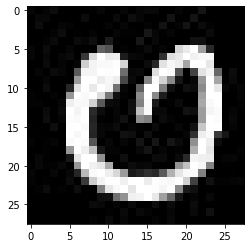

In [13]:
img = images[88]
plt.imshow(img)

# Preparing training and testing data for the CNN Model
The test dataset will be made use of later to test the accuracy

In [14]:
x_train, x_test, y_train, y_test = train_test_split(images, train_csv, test_size = 0.1, random_state = 42)

Dealing with Imbalanced Dataset Using Class Weight Hyper Parameter

In [15]:
# prepaing values for class weight parameter
zero = len(y_train[y_train['label']==0])
one = len(y_train[y_train['label']==1])
total = len(y_train)

weight_for_0 = (1 / zero) * (total)/2.0 
weight_for_1 = (1 / one)  * (total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

Cleaning the labels array

In [16]:
y_train = np.array(y_train.drop(['id'],axis=1)).flatten()
y_test = np.array(y_test.drop(['id'],axis=1)).flatten()

# **CNN Model**

After much trail and error, the number of layers, units within each layer, kernel size, pool size and drop out hyperparameters were finalised, such that the accuracy on the test set was the highest. Another note would be the point from the week 6 notebook: 

We can reach 98.2% test accuracy with the following configuration:
First hidden layer of 256 nodes; second hidden layer of 128 nodes. Dropout regularization rate of 0.2 

Taking this into account and several trial and error, the best parameters were found.


# Defining the models

In [17]:
# CNN Model derived from Week 6 lecture code

def cnn_model():

  # This method defines a simple CNN model

  # Parameters: None
  
  # Return simple CNN model for image classification

    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(28,28,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='Adam', loss='binary_crossentropy',  metrics=['accuracy'])

    return model

Alternative CNN model, with slight changes in the second convulational layer: Reduction in kernel size and pool size from layer 1

In [18]:
def alt_cnn_model():

  # This method defines an alternative CNN model, slightly different from the previous one. 

  # Parameters: None
  
  # Return alternative CNN model for image classification

    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(28,28,3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 1)))
    model.add(Dropout(0.25))
    # model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    # model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='Adam', loss='binary_crossentropy',  metrics=['accuracy'])

    return model

Defining a Kfold cross-validation model. The previous models can be compiled and fitted in this structure

In [19]:
def kfold_model(model_, x_train, y_train, class_weight):  

  # This method defines the KFold Cross Validation for the CNN model. It also prints important statistics after each fold and at the end of the entire CV process. 
  
  # Parameters: 
  #   model_: any compatible cnn model, cnn_model() or alt_cnn_model() can be used
  #   x_train: set of training images
  #   y_train: set of labels corresponding to the training images
  #   class_weight: dictionary containing the class weights corresponding to both the classes

  # Return CNN model for image classification fitted against the training data in a cross-validation process

    acc_per_fold = []
    loss_per_fold = []
    kfold = KFold(n_splits=10, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(x_train, y_train):

        # Compile the model
        model_.compile(loss='binary_crossentropy',  optimizer='Adam', metrics=['accuracy'])


        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit data to model
        history = model_.fit(x_train[train], y_train[train],
                    batch_size=32,
                    epochs=10, callbacks = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3), class_weight = class_weight)

        # Generate generalization metrics
        scores = model_.evaluate(x_train[test], y_train[test], verbose=0)
        print(f'Score for fold {fold_no}: {model_.metrics_names[0]} of {scores[0]}; {model_.metrics_names[1]} of {scores[1]*100}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])

        # Increase fold number
        fold_no = fold_no + 1

  # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')

    return model_

Cross-entropy loss, or log loss, measure the performance of a classification model whose output is a probability value between 0 and 1. It is preferred for classification. 

# **Model Training**

Early Stopping has been used in all models to prevent overfitting

In [20]:
model_1 = cnn_model()
model_1.fit(x_train, y_train, validation_split = 0.5, epochs=10, batch_size=32, callbacks = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3), class_weight = class_weight)
model_1.summary()

Epoch 1/10
91/91 [==============================] - 3s 38ms/step - loss: 0.1263 - accuracy: 0.9672 - val_loss: 0.0058 - val_accuracy: 0.9986
Epoch 2/10
91/91 [==============================] - 3s 34ms/step - loss: 0.0098 - accuracy: 0.9962 - val_loss: 0.0018 - val_accuracy: 0.9997
Epoch 3/10
91/91 [==============================] - 3s 32ms/step - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.0041 - val_accuracy: 0.9979
Epoch 4/10
91/91 [==============================] - 3s 33ms/step - loss: 0.0102 - accuracy: 0.9965 - val_loss: 0.0055 - val_accuracy: 0.9979
Epoch 5/10
91/91 [==============================] - 3s 33ms/step - loss: 0.0108 - accuracy: 0.9969 - val_loss: 0.0065 - val_accuracy: 0.9979
Epoch 6/10
91/91 [==============================] - 3s 33ms/step - loss: 0.0062 - accuracy: 0.9986 - val_loss: 0.0018 - val_accuracy: 0.9990
Epoch 7/10
91/91 [==============================] - 3s 33ms/step - loss: 5.7250e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 0.9993
Epoch 8/1

In [21]:
model_2 = alt_cnn_model()
model_2.fit(x_train, y_train, validation_split = 0.5, epochs=10, batch_size=32, callbacks = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3), class_weight = class_weight)
model_2.summary()

Epoch 1/10
91/91 [==============================] - 4s 40ms/step - loss: 0.0624 - accuracy: 0.9831 - val_loss: 0.0094 - val_accuracy: 0.9965
Epoch 2/10
91/91 [==============================] - 4s 39ms/step - loss: 0.0132 - accuracy: 0.9969 - val_loss: 0.0204 - val_accuracy: 0.9959
Epoch 3/10
91/91 [==============================] - 4s 39ms/step - loss: 0.0101 - accuracy: 0.9972 - val_loss: 0.1070 - val_accuracy: 0.9775
Epoch 4/10
91/91 [==============================] - 4s 39ms/step - loss: 0.0110 - accuracy: 0.9969 - val_loss: 0.0184 - val_accuracy: 0.9969
Epoch 5/10
91/91 [==============================] - 3s 38ms/step - loss: 0.0035 - accuracy: 0.9986 - val_loss: 0.0187 - val_accuracy: 0.9969
Epoch 6/10
91/91 [==============================] - 4s 39ms/step - loss: 0.0025 - accuracy: 0.9986 - val_loss: 6.9520e-04 - val_accuracy: 0.9997
Epoch 7/10
91/91 [==============================] - 4s 39ms/step - loss: 4.1619e-04 - accuracy: 0.9997 - val_loss: 2.8047e-04 - val_accuracy: 1.0000
E

# CNN Model with K-Fold

In [22]:
model_3 = cnn_model()
model_3 = kfold_model(model_3, x_train, y_train, class_weight)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
163/163 [==============================] - 4s 26ms/step - loss: 0.0762 - accuracy: 0.9877
Epoch 2/10
163/163 [==============================] - 4s 25ms/step - loss: 0.0144 - accuracy: 0.9952
Epoch 3/10
163/163 [==============================] - 4s 26ms/step - loss: 0.0085 - accuracy: 0.9977
Epoch 4/10
163/163 [==============================] - 4s 26ms/step - loss: 0.0019 - accuracy: 0.9992
Epoch 5/10
163/163 [==============================] - 4s 25ms/step - loss: 3.7477e-04 - accuracy: 1.0000
Epoch 6/10
163/163 [==============================] - 4s 25ms/step - loss: 0.0044 - accuracy: 0.9990
Epoch 7/10
163/163 [==============================] - 4s 26ms/step - loss: 0.0174 - accuracy: 0.9952
Epoch 8/10
163/163 [==============================] - 4s 25ms/step - loss: 0.0022 - accuracy: 0.9994
Score for fold 1: loss of 0.014360159635543823; accuracy of 99.82728958129883%
------------

In [23]:
model_4 = alt_cnn_model()
model_4 = kfold_model(model_4, x_train, y_train, class_weight)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
163/163 [==============================] - 5s 30ms/step - loss: 0.0912 - accuracy: 0.9873
Epoch 2/10
163/163 [==============================] - 5s 30ms/step - loss: 0.0276 - accuracy: 0.9950
Epoch 3/10
163/163 [==============================] - 5s 30ms/step - loss: 0.0052 - accuracy: 0.9985
Epoch 4/10
163/163 [==============================] - 5s 31ms/step - loss: 0.0078 - accuracy: 0.9975
Epoch 5/10
163/163 [==============================] - 5s 30ms/step - loss: 0.0086 - accuracy: 0.9975
Epoch 6/10
163/163 [==============================] - 5s 30ms/step - loss: 0.0027 - accuracy: 0.9992
Epoch 7/10
163/163 [==============================] - 5s 30ms/step - loss: 1.5658e-04 - accuracy: 1.0000
Epoch 8/10
163/163 [==============================] - 5s 30ms/step - loss: 1.6803e-04 - accuracy: 1.0000
Epoch 9/10
163/163 [==============================] - 5s 30ms/step - loss: 0.0087 - acc

## Testing the accuracy against test set

Highly important part of this project where we test the trained model against the test data. By predicting the proba on unseen data, we can calculate the accuracy of the model on an out-of-sample dataset. This function also plots the probas of 0 and 1 separately to see how good of a distinguishment it can make between the classes.

In [24]:
def plot_probas(model, x_test, y_test):
    
    # This method helps predict proba on the test set.
    # It also plots the probas separately for both classes to see how well the model can differentiate anomaly from normal data
    
    # Parameters: 
    #  model: the trained cnn model
    #  x_test: test set of images
    #  y_test: labels in the test set
    
    # Returns: None

    output = []

    for i in range(x_test.shape[0]):

        img = x_test[i]
        proba = pd.DataFrame(model_1.predict(img.reshape(1,28,28,3))).iloc[0][0]
        output = np.append(output, proba)


    print("Accuracy score is: " + str(sklearn.metrics.roc_auc_score(y_test, output)))

    y_test_df = pd.DataFrame(y_test)
    ones = y_test_df[y_test_df[0]==1].index.values
    zeroes = y_test_df[y_test_df[0]==0].index.values
    x_ones = output[ones]
    x_zeroes = output[zeroes]


    plt.plot(range(len(x_zeroes)), x_zeroes, linestyle='-', linewidth=1, label="Probas of Zeroes")
    plt.legend(loc='best')
    plt.grid()
    plt.xlabel('sample index')
    plt.ylabel('proba')
    plt.show()


    plt.plot(range(len(x_ones)), x_ones, linestyle='-', linewidth=1, label="Probas of Ones")
    plt.legend(loc='best')
    plt.grid()
    plt.xlabel('sample index')
    plt.ylabel('proba')
    plt.show()


  

Simple CNN Model

Accuracy score is: 1.0


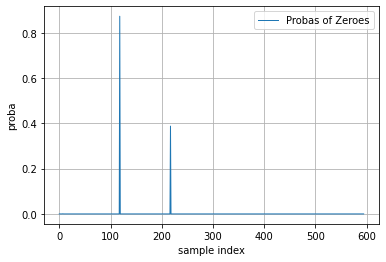

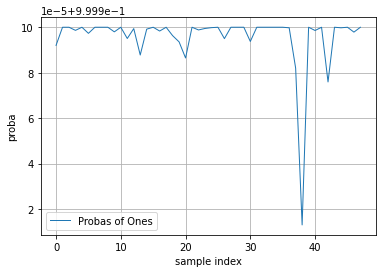

In [25]:
plot_probas(model_1, x_test, y_test)

Alternative CNN Model

Accuracy score is: 1.0


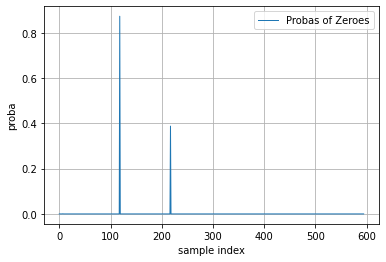

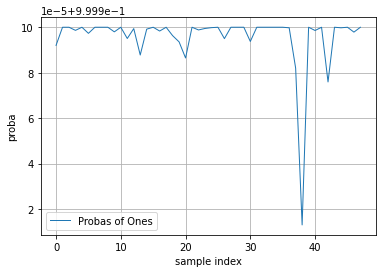

In [26]:
plot_probas(model_2, x_test, y_test)

Simple CNN Model with KFold CV

Accuracy score is: 1.0


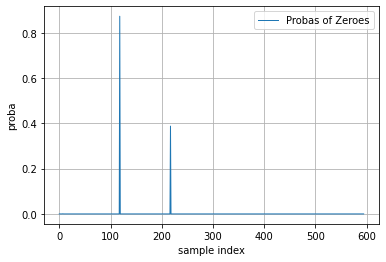

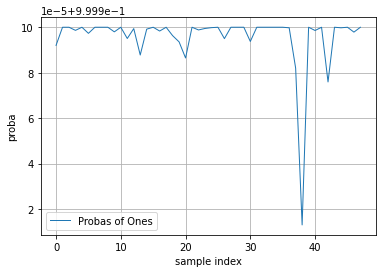

In [27]:
plot_probas(model_3, x_test, y_test)

Alternate CNN Model with KFold CV

Accuracy score is: 1.0


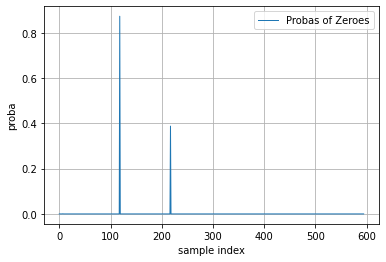

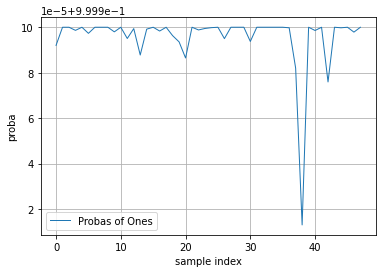

In [28]:
plot_probas(model_4, x_test, y_test)

# **Autoencoder**

# Choosing train, test and anomaly rows

Choosing train rows; 4500 rows of normal data

In [29]:
zero = train_csv[train_csv.label == 0].index.values   # selects the 0 values
train_rows = np.random.choice(zero, 4500, replace = False) 

# to follow the same order of indexing 
train_rows.sort() 


x_train = images_autoencoder[train_rows]
y_train = train_csv.iloc[train_rows]
y_train = np.array(y_train.drop(['id'],axis=1))

Choosing test rows; 500 rows of normal data, separate from the training set

In [30]:
diff_zero = np.setdiff1d(zero, train_rows)
test_rows = np.random.choice(diff_zero, 500, replace = False) 

# to follow the same order of indexing 
test_rows.sort()

x_test = images_autoencoder[test_rows]
y_test = train_csv.iloc[test_rows]
y_test = np.array(y_test.drop(['id'],axis=1))

Choosing Anomaly Rows; 500 rows of anomalous data.

In [31]:
anomaly_rows = train_csv[train_csv.label == 1].index.values    # selects the 1 values

# to follow the same order of indexing 
anomaly_rows.sort()

x_anomaly = images_autoencoder[anomaly_rows]
y_anomaly = train_csv.iloc[anomaly_rows]
y_anomaly = np.array(y_anomaly.drop(['id'],axis=1))

# Processing of train, test and anomaly sets

Normalising the values (between 0 and 1)

In [32]:
x_train = x_train/255
x_test = x_test/255
x_anomaly = x_anomaly/255
test_images_autoencoder = test_images_autoencoder/255

Reshaping of datasets

In [33]:
x_train = x_train.reshape(-1,28*28)
x_test = x_test.reshape(-1,28*28)
x_anomaly = x_anomaly.reshape(-1,28*28)
test_images_autoencoder = test_images_autoencoder.reshape(-1,28*28)

Will require this concatenated data for plotting losses later

In [34]:
x_concat = np.concatenate([x_test, x_anomaly], axis=0)

# Defining Autencoder and Deep Autoencoder models

In [35]:
def autoencoder_model():

  # This method defines a simple autoencoder model, with just 2 layers in the sequence
  
  # Parameters: None

  # Returns: an autoencoder model 
  
    input_shape=(784,)
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=input_shape))
    model.add(Dense(784, activation='sigmoid'))

    return model


In [36]:
def deep_autoencoder_model():

  # This method defines a deep autoencoder model, with 4 layers in the sequence
  
  # Parameters: None

  # Returns: a deep autoencoder model 

    input_shape=(784,)
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=input_shape))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(784, activation='sigmoid'))
    return model

# Defining method to compute loss by testing model on test set

Testing the trained model against the test data. By computing the loss occurred during reconstruction of the images by the autoencoder model on an out-of-sample dataset, we can see how clear cut of a threshold exists between both the classes. Clearer the threshold, better the ROC score. (The losses can serve as probabilities too)

In [37]:
def compute_losses(model, data, name, show_plot = True):

  # This method computes the reconstruction error, given a fitted model and the test set. It plots and stores the losses
  
  # Parameters: 
  #   model: any compatible autoencoder model
  #   data: the test data set (in our case, the 500 rows of normal data and 500 rows of anomalous data)
  #   name: name of the model (string value)
  #   show_plot: Default is true -> Will display the plot with the sample index and corresponding losses. If False, plot will be hidden

  # Returns: the array or losses/reconstruction error for the test and anomaly data

    losses = []
    for x in data:
        # compule loss for each test sample
        x = np.expand_dims(x, axis=0)
        loss = model.test_on_batch(x, x)
        losses.append(loss)

    if (show_plot):
        plt.plot(range(len(losses)), losses, linestyle='-', linewidth=1, label=name)
        plt.legend(loc='best')
        plt.grid()
        plt.xlabel('sample index')
        plt.ylabel('loss')
        plt.show()

    return losses

Training the autoencoder model

In [38]:
model_auto = autoencoder_model()
model_auto.compile(optimizer='adam', loss='mean_squared_error')

# train on only normal training data
model_auto.fit(x_train, x_train, epochs=10,  batch_size=64)

Epoch 1/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0853
Epoch 2/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0402
Epoch 3/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0321
Epoch 4/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0271
Epoch 5/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 6/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 7/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0184
Epoch 8/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 9/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 10/10
71/71 [==============================] - 0s 3ms/step - loss: 0.0141


Plotting the losses when the autoencoder model tries to reconstruct the test and anomaly images

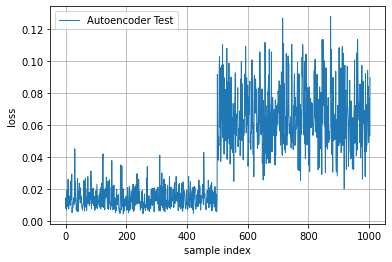

In [39]:
losses_autoencoder = compute_losses(model_auto, x_concat, 'Autoencoder Test')

Training the deep autoencoder model

In [40]:
model_deep = deep_autoencoder_model()
model_deep.compile(optimizer='adam', loss='mean_squared_error')

# train on only normal training data
model_deep.fit(x_train, x_train, epochs=10,  batch_size=64)

Epoch 1/10
71/71 [==============================] - 0s 5ms/step - loss: 0.0794
Epoch 2/10
71/71 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 3/10
71/71 [==============================] - 0s 5ms/step - loss: 0.0261
Epoch 4/10
71/71 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 5/10
71/71 [==============================] - 0s 6ms/step - loss: 0.0169
Epoch 6/10
71/71 [==============================] - 0s 5ms/step - loss: 0.0148
Epoch 7/10
71/71 [==============================] - 0s 6ms/step - loss: 0.0136
Epoch 8/10
71/71 [==============================] - 0s 5ms/step - loss: 0.0128
Epoch 9/10
71/71 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 10/10
71/71 [==============================] - 0s 5ms/step - loss: 0.0115


Plotting and storing the losses when the deep autoencoder model tries to reconstruct the test and anomaly images

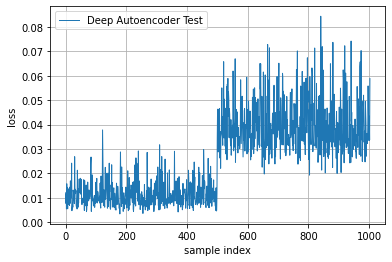

In [41]:
losses_deep = compute_losses(model_deep, x_concat, 'Deep Autoencoder Test')

# Running model on Kaggle Submission Data

Storing the losses when the autoencoder model tries to reconstruct the kaggle output images. Since it seems that the autoencoder model has a clear threshold between the reconstruction error of normal data and that of anomalous data, the losses itself can be submitted as the final proba for the Kaggle competition

In [42]:
output_losses = compute_losses(model_auto, test_images_autoencoder, 'Kaggle Data', show_plot = False)

# Saving as CSV File

In [43]:
output = pd.DataFrame(output_losses, columns=['target'])
output.index.name = "id"
output.to_csv("/content/drive/My Drive/submission.csv") 
